In [1]:
pip install contextily

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pandas geopandas matplotlib contextily folium shapely

Note: you may need to restart the kernel to use updated packages.


/var/folders/ht/4s2__9f90hx5p1zgb20_5nz40000gn/T/ipykernel_6080/3573633745.py:10: DtypeWarning: Columns (18,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(bird_strikes_csv)


Original Columns in DataFrame:
Index(['INDEX_NR', 'INCIDENT_DATE', 'INCIDENT_MONTH', 'INCIDENT_YEAR', 'TIME',
       'TIME_OF_DAY', 'AIRPORT_ID', 'AIRPORT', 'LATITUDE', 'LONGITUDE',
       'RUNWAY', 'STATE', 'FAAREGION', 'LOCATION', 'ENROUTE_STATE', 'OPID',
       'OPERATOR', 'REG', 'FLT', 'AIRCRAFT', 'AMA', 'AMO', 'EMA', 'EMO',
       'AC_CLASS', 'AC_MASS', 'TYPE_ENG', 'NUM_ENGS', 'ENG_1_POS', 'ENG_2_POS',
       'ENG_3_POS', 'ENG_4_POS', 'PHASE_OF_FLIGHT', 'HEIGHT', 'SPEED',
       'DISTANCE', 'SKY', 'PRECIPITATION', 'AOS', 'COST_REPAIRS', 'COST_OTHER',
       'COST_REPAIRS_INFL_ADJ', 'COST_OTHER_INFL_ADJ', 'INGESTED_OTHER',
       'INDICATED_DAMAGE', 'DAMAGE_LEVEL', 'STR_RAD', 'DAM_RAD',
       'STR_WINDSHLD', 'DAM_WINDSHLD', 'STR_NOSE', 'DAM_NOSE', 'STR_ENG1',
       'DAM_ENG1', 'ING_ENG1', 'STR_ENG2', 'DAM_ENG2', 'ING_ENG2', 'STR_ENG3',
       'DAM_ENG3', 'ING_ENG3', 'STR_ENG4', 'DAM_ENG4', 'ING_ENG4', 'STR_PROP',
       'DAM_PROP', 'STR_WING_ROT', 'DAM_WING_ROT', 'STR_FUSE', 'DAM

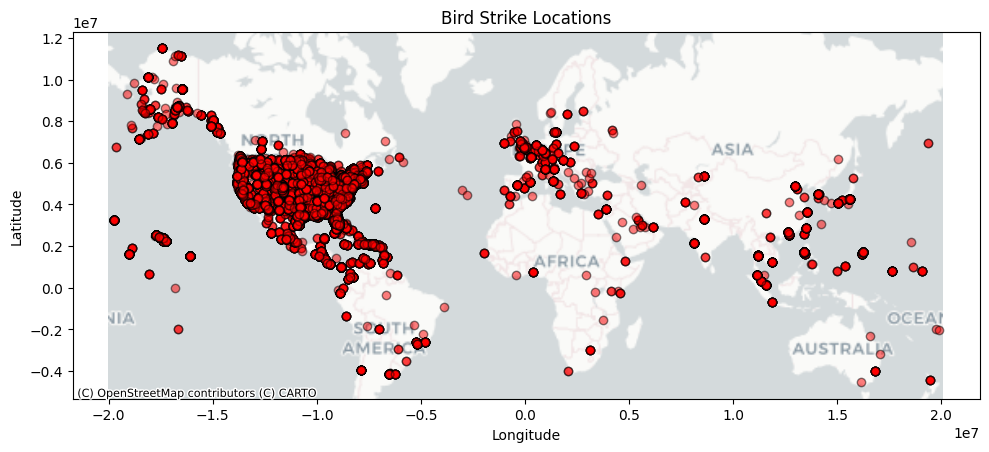


Heatmap saved as 'bird_strikes_heatmap.html'. Open this file in a web browser to view the interactive map.

Airports data file not found. Skipping proximity analysis.

--- Geospatial Analysis Complete ---


In [5]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point
import folium
from folium.plugins import HeatMap

bird_strikes_csv = 'Bird_Strikes_1990_2023.csv'  
df = pd.read_csv(bird_strikes_csv)
print("Original Columns in DataFrame:")
print(df.columns)

# Normalize column names to lowercase
df.columns = df.columns.str.lower()
print("\nNormalized Columns:")
print(df.columns)

try:
    geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
except KeyError as e:
    raise KeyError(f"Missing expected column in CSV: {e}. Please check your column names.")

gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
print("\nGeoDataFrame (first 5 rows):")
print(gdf.head())
print("CRS:", gdf.crs)

gdf_web_mercator = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 6))
gdf_web_mercator.plot(ax=ax, marker='o', color='red', alpha=0.5, edgecolor='black')

# Add basemap using CartoDB Positron
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title('Bird Strike Locations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

gdf_heat = gdf.dropna(subset=['latitude', 'longitude'])
heat_data = gdf_heat[['latitude', 'longitude']].values.tolist()

# Create a Folium map centered on the average location of all bird strikes
m = folium.Map(
    location=[gdf_heat['latitude'].mean(), gdf_heat['longitude'].mean()],
    zoom_start=5,
    tiles='Stamen Terrain',
    attr='Map tiles by Stamen, CC BY 3.0 — Map data © OpenStreetMap'
)

HeatMap(heat_data, radius=10, blur=15, max_zoom=13).add_to(m)

# Save map to HTML (optional)
m.save('bird_strikes_heatmap.html')
print("\nHeatmap saved as 'bird_strikes_heatmap.html'. Open this file in a web browser to view the interactive map.")

try:
    airports_csv = 'airports.csv'  # Adjust path/filename as needed
    df_airports = pd.read_csv(airports_csv)
    print("\nOriginal Airports DataFrame Columns:")
    print(df_airports.columns)
    
    # Normalize airport DataFrame columns to lowercase
    df_airports.columns = df_airports.columns.str.lower()
    print("\nNormalized Airports DataFrame Columns:")
    print(df_airports.columns)
    
    # Create GeoDataFrame for airports
    geometry_airports = [Point(xy) for xy in zip(df_airports['airport_lon'], df_airports['airport_lat'])]
    gdf_airports = gpd.GeoDataFrame(df_airports, geometry=geometry_airports, crs="EPSG:4326")
    gdf_airports_web = gdf_airports.to_crs(epsg=3857)

    # Calculate the distance from each bird strike to the nearest airport
    distances = []
    for strike_geom in gdf_web_mercator.geometry:
        nearest_dist = gdf_airports_web.distance(strike_geom).min()
        distances.append(nearest_dist)

    gdf_web_mercator['dist_to_airport_m'] = distances
    gdf_web_mercator['dist_to_airport_km'] = gdf_web_mercator['dist_to_airport_m'] / 1000.0

    print("\nDistance to Nearest Airport (km) - Summary:")
    print(gdf_web_mercator['dist_to_airport_km'].describe())

    # (Optional) Plot a histogram of distances
    plt.figure(figsize=(8, 4))
    plt.hist(gdf_web_mercator['dist_to_airport_km'], bins=30, color='skyblue', edgecolor='black')
    plt.title('Histogram of Bird Strike Distance to Nearest Airport')
    plt.xlabel('Distance (km)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("\nAirports data file not found. Skipping proximity analysis.")
except KeyError as e:
    print(f"\nAirports file is missing required columns: {e}. Skipping proximity analysis.")

print("\n--- Geospatial Analysis Complete ---")

Explanation of the Bird Strike Incident Map
1. Description of the Visualization

This is a global map displaying the locations of bird strike incidents.
Each red dot represents a recorded bird strike event.
The background map provides geographical context, helping to identify patterns in where bird strikes occur.
2. Key Observations

High Density in North America:
The majority of bird strike incidents appear to be concentrated in the United States.
This is expected as the U.S. has one of the busiest aviation networks in the world, with a large number of commercial and military flights.
Clusters in Europe and Asia:
A significant number of incidents are also reported in Western Europe (France, Germany, the UK).
Some cases are visible in India, China, and Southeast Asia, likely around major international airports.
Fewer Reports in Africa and South America:
There are relatively fewer incidents reported in Africa and South America.
This could be due to less air traffic or underreporting of bird strike incidents in these regions.
3. Possible Explanations for These Patterns

High air traffic = More bird strikes: The locations with the most incidents correspond to regions with high-density airports and frequent flight activity.
Urbanization and bird populations: Areas with high urbanization and migratory bird paths tend to have more bird strikes.
Data collection bias: Countries with more strict aviation regulations (e.g., the U.S. and Europe) might have better bird strike reporting systems.
4. Additional Analysis

Hotspot Analysis: A heatmap overlay could help to identify the most affected airports.
Time Analysis: A year-over-year analysis can determine if bird strike frequency is increasing or decreasing over time.
Seasonal Patterns: Bird strikes often peak during migration seasons (spring and autumn), which could be further investigated.